# Result Exploration
This notebook helps to build functions for printing results of CNN training.

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Scripts import Print_Functions as PF
from Scripts import Centralized_CNN as cNN

FIGURES = os.path.join(module_path, "Figures")

## Define Helper Functions

In [3]:
def aggregate_df(df, cols):
    return df[cols].drop_duplicates().reset_index(drop=True)

In [4]:
def make_pain_plot(folder, params, file_ending, agg_cols=None):
    files = os.listdir(folder)
    files = [os.path.join(folder, file) for file in files if file.endswith('{}.csv'.format(file_ending))]
    files = sorted(files)

    legend = []
    rounds = 30
    for idx, file in enumerate(files):
#         idx *= 2
        df = pd.read_csv(file)
        if agg_cols is not None:
            df = aggregate_df(df, agg_cols)
        
        plt.plot(df[params.metric], color=params.colors[idx])
        for i, j in df[params.metric][:params.max_epochs].items():
            if not int(i) % params.label_spaces:
                plt.text(i, j, params.num_format.format(j), color='black',
                         bbox=dict(facecolor='white', edgecolor=params.colors[idx], boxstyle='round'))

        legend.append('0% Group 1 + {0:.0%} Group 2'.format(float(file.split('shard-')[1].split('_')[0])))

    plt.legend(legend, loc=params.legend_loc)
    plt.title('{} | {} | Group 1 + X% Group 2'.format(params.metric, params.experiment))
    plt.yticks(np.arange(0.3, 1.05, step=0.05))
    plt.ylabel('{}'.format(params.metric))
    plt.xticks(np.arange(0, rounds+1, step=1))
    plt.xlabel('Epoch / Communication Round')
    fig = plt.gcf()
    fig.set_size_inches((12, 8), forward=False)
    file = time.strftime("%Y-%m-%d-%H%M%S") + r"_{}_{}_{}.png".format(params.dataset, params.experiment, params.metric)
#     plt.savefig(os.path.join(FIGURES, file), dpi=300)
    plt.show()
    plt.clf()
    return plt

In [5]:
# Set Parameters
params = PF.PlotParams(
            dataset='Pain',
            experiment='Centralized',
            metric='',
            legend_loc='best',
            num_format="{:5.1%}",
            max_epochs=None,
            label_spaces=4
)

## Prepare Plots for Aggregate Metrics

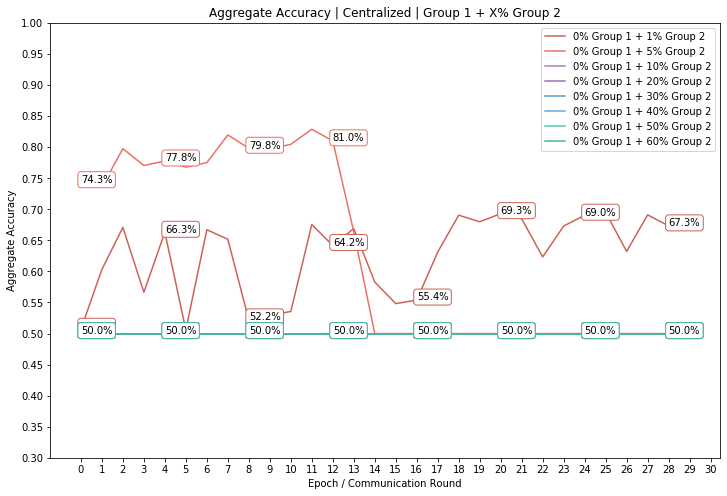

<Figure size 432x288 with 0 Axes>

In [8]:
# Prepare Aggregate Plots
path_1 = '/Users/nico/PycharmProjects/FederatedLearning/Results/2019-07-26_PAIN_Balanced_Test/2019-07-26_PAIN_Centralized-no-pre-training'
path_2 = '/Users/nico/PycharmProjects/FederatedLearning/Results/2019-07-26_PAIN_Balanced_Test/2019-07-26_PAIN_Centralized-pre-training'
path_3 = '/Users/nico/PycharmProjects/FederatedLearning/Results/2019-07-26_PAIN_Balanced_Test/2019-07-26_PAIN_Federated-central-pre-training'
path_4 = '/Users/nico/PycharmProjects/FederatedLearning/Results/2019-07-26_PAIN_Balanced_Test/2019-07-26_PAIN_Federated-federated-pre-training'
path_5 = '/Users/nico/PycharmProjects/FederatedLearning/Results/2019-07-26_PAIN_Balanced_Test/2019-07-26_PAIN_Federated-no-pre-training'
path_6 = '/Users/nico/PycharmProjects/FederatedLearning/Results/2019-07-27_Unbalanced_Test/2019-07-27_PAIN_Federated-federated-pre-training'
# path = "/Users/nico/PycharmProjects/FederatedLearning/Results/2019-07-26_PAIN_Balanced_Test/2019-07-26_PAIN_Federated-no-pre-training"
aggregate_cols = ['Epoch', 'Loss', 'Aggregate Avg. Precision', 'Aggregate Accuracy', 
                  'Aggregate Precision', 'Aggregate Recall', 'Aggregate F1_Score']
metrics = ['Aggregate Accuracy', 
#            'Aggregate Precision', 
#            'Aggregate Recall', 
#            'Aggregate F1_Score', 
#            'Aggregate Avg. Precision'
          ]
for metric in metrics:
    params.metric = metric
    make_pain_plot(path_1, params, "individual", aggregate_cols)

## Prepare plots for Individual metrics

In [ ]:
# Individual plotting
metrics = ['Individual Accuracy', 'Individual Precision', 'Individual Recall', 'Individual F1-Score', 'Individual Avg. Precision']
folder = "/Users/nico/PycharmProjects/FederatedLearning/Results/PAIN 2019-07-25 Federated Clients-12"
ending = 12
files = os.listdir(folder)
files = [os.path.join(folder, file) for file in files if file.endswith('{}.csv'.format(ending))]
files = sorted(files)

for metric in metrics:
    params.metric = metric
    fig = plt.figure(dpi=300)
    for idx, file in enumerate(files):
        df = pd.read_csv(file, index_col=0)
        df['Person'] = df['Person'].astype(int)
        pivot = df.pivot(index='Epoch', columns='Person', values=params.metric)
        percent = float(file.split('shard-')[1].split('_')[0])
        rounds = float(file.split('rounds_')[1].split('_')[0])
        ax = pivot.plot(
            title="{} | {} | Group 1 + {:.0%} Group 2".format(params.metric, params.experiment, percent),
            yticks=np.arange(0.0, 1.05, step=0.05),
            xticks=np.arange(0, rounds+1, step=1),
            figsize=(16,24),
            ax=fig.add_subplot(4, 2, idx+1),
        )
        ax.set_xlabel('Epoch / Communication Round')
        ax.set_ylabel("{}".format(params.metric))
    f_name = time.strftime("%Y-%m-%d-%H%M%S") + r"_{}_{}_{}.png".format(params.dataset, params.experiment, params.metric)
    plt.savefig(os.path.join(FIGURES, f_name), dpi=300)